**Подключение библиотек и скриптов**

In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, GridSearchCV
import seaborn as sns
%matplotlib inline

In [141]:
#пишем функцию, создающую переменную, у которой каждое значение будет средним значением
#количественной переменной (real_future), взятым по уровню
#категориальной переменной
def code_mean(df, cat_feature, real_feature):
    return (df[cat_feature].map(df.groupby(cat_feature)[real_feature].mean()))


def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

**Пути к директориям и файлам**

In [142]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

### Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [143]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


In [144]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
4999,12504,30,2.0,60.555693,NaN,1.0,10,17.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B


### Приведение типов

In [145]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

~~Назначем в качестве индекса стобец **Id**, тем самым исключаем его из признаков для построения модели~~

**DistrictId** - идентификационный номер района, является категориальным признаком, меняем ему типа на _str_

In [146]:
#train_df = train_df.set_index('Id')
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

In [147]:
train_df['HouseFloor'] = train_df['HouseFloor'].astype(np.int64)

### Обзор данных

**Целевая переменная**

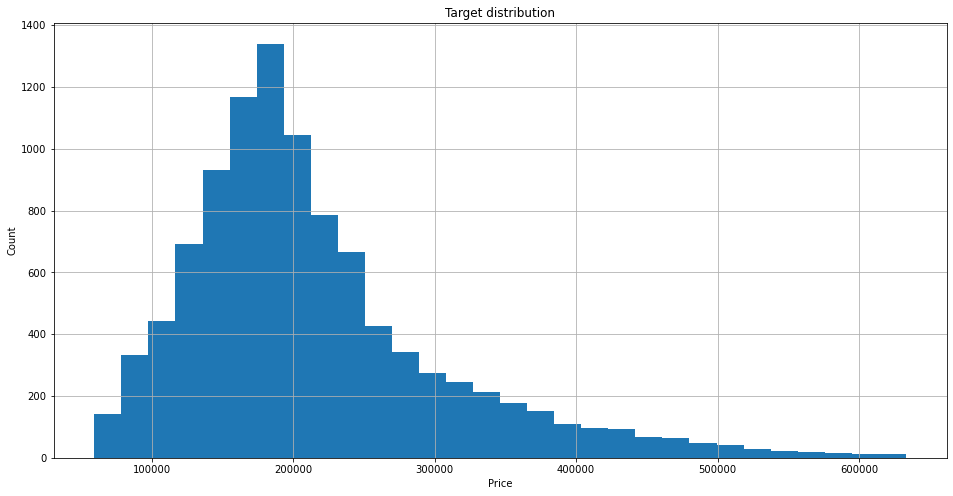

In [148]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

Ценовых аномалий не замечено

**Количественные переменные**

In [149]:
train_df.describe()

,Id,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


**Номинативные переменные**

In [150]:
train_df.select_dtypes(include='object').columns.tolist()

['DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [151]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
207      1
117      1
174      1
205      1
209      1
Name: DistrictId, Length: 205, dtype: int64

In [152]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [153]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [154]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### Аномальные значения и выбросы

**Количество комнат**

In [155]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Удалим из выборки элементы с количеством комнат 0, 10, 19 и 6, т.к. их общее количество всего  0.12%

In [156]:
train_df.drop(train_df[train_df['Rooms'].isin([0,10,19,6])].index, inplace=True)
len(train_df)

9988

**Значения площадей (Square, LifeSquare, KitchenSquare)**

Отбросим крайние 0.5% выборки по значениям площадей. У площадей кухонь отбросим только верхние 0.5% элементов, а значниея ниже 3 приравняем к 3.

In [157]:
q_max = 0.995
q_min = 0.005
train_df = train_df[train_df['Square'].isnull() |
        (train_df['Square'] < train_df['Square'].quantile(q_max)) &
        (train_df['Square'] > train_df['Square'].quantile(q_min))]
train_df = train_df[train_df['LifeSquare'].isnull() |
        (train_df['LifeSquare'] < train_df['LifeSquare'].quantile(q_max)) &
        (train_df['LifeSquare'] > train_df['LifeSquare'].quantile(q_min))]
train_df = train_df[train_df['KitchenSquare'].isnull() |
                    (train_df['KitchenSquare'] < train_df['KitchenSquare'].quantile(q_max))]

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

**Этажность дома (HouseFloor, Floor)**

Нулевые значения этажности дома заменим медианой

In [158]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

Если этаж квартиры превышает этажность дома, заменим этаж случайным значением из диапазана _1..HouseFloor_

In [159]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: np.random.randint(1, x+1))


**Год постройки дома (HouseYear	)**

In [160]:
train_df['HouseYear'].sort_values()

5111        1912
910         1914
7611        1916
8144        1917
1380        1917
          ...   
8253        2020
9674        2020
5701        2020
4189        4968
1497    20052011
Name: HouseYear, Length: 9750, dtype: int64

Сразу бросается в глаза два аномальных значения - '20052011' и '4968'. '20052011' мы заменим на 2011, а значения больше 2020 заменим на 2020

In [161]:
train_df.loc[train_df['HouseYear'] == 20052011, 'HouseYear'] = 2011
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

### Обработка пропусков

In [162]:
(len(train_df) - train_df.count())/len(train_df)

Id               0.000000
DistrictId       0.000000
Rooms            0.000000
Square           0.000000
LifeSquare       0.213641
KitchenSquare    0.000000
Floor            0.000000
HouseFloor       0.000000
HouseYear        0.000000
Ecology_1        0.000000
Ecology_2        0.000000
Ecology_3        0.000000
Social_1         0.000000
Social_2         0.000000
Social_3         0.000000
Healthcare_1     0.477641
Helthcare_2      0.000000
Shops_1          0.000000
Shops_2          0.000000
Price            0.000000
dtype: float64

Есть пропуски в данных: **LifeSquare** ~23% и **Healthcare_1** ~47%.

Пропусков больше 5%, поэтому удалять мы их не можем, а будем обрабатывать по хитрой формуле: LifeSquare = Square - KitchenSquare - "медиана выражения (Square - LifeSquare - KitchenSquare), на выборке, где значение LifeSquare не пропущено"

In [163]:
square_med_diff = (train_df.loc[train_df['LifeSquare'].notnull(), 'Square'] -\
                   train_df.loc[train_df['LifeSquare'].notnull(), 'LifeSquare'] -\
                   train_df.loc[train_df['LifeSquare'].notnull(), 'KitchenSquare']).median()

square_med_diff

11.397402662515148

In [164]:
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] =\
train_df.loc[train_df['LifeSquare'].isnull(), 'Square'] -\
train_df.loc[train_df['LifeSquare'].isnull(), 'KitchenSquare'] -\
square_med_diff
train_df['LifeSquare'].median()

33.73118376694839

Пустые значения **Healthcare_1** заменим просто медианой

In [165]:
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

### Построение новых признаков

**Dummies**

In [166]:
train_df['Ecology_2_bin'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
train_df['Ecology_3_bin'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
train_df['Shops_2_bin'] = train_df['Shops_2'].replace({'A':0, 'B':1})

**Размер района (DistrictSize, IsDistrictLarge)**

In [167]:
district_size = train_df['DistrictId'].value_counts().reset_index().rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
train_df = train_df.merge(district_size, on='DistrictId', how='left')

Добавляем новый категориальный признак большого района (где домов больше 100)

In [168]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

**Средняя цена по району, с учётом количества комнат (MedPriceByDistrict)**

In [169]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                        .rename(columns={'Price':'MedPriceByDistrict'})
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')

### Отбор признаков

In [170]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict']

Отберём признаки, которые будем использовать в модели для обучения

In [171]:
#feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
#                 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3',
 #                'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin']
#Когда мы отбросили самые малозначимые признаки: 'Ecology_2_bin', 'Ecology_3_bin', 'Shops_2_bin', 
# то качество модели немного увеличилось
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1']
new_feature_names = ['IsDistrictLarge', 'MedPriceByDistrict']

target_name = 'Price'

### Разбиение на train и test

In [172]:
X = train_df[feature_names + new_feature_names]
y = train_df[target_name]

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

### Построение модели

**Обучение и оценка модели**

In [174]:
#0.7485463221395934
#rf_model = RandomForestRegressor(random_state=21)

#0.7513681154103388
#rf_model = RandomForestRegressor(n_estimators=1100, random_state=21)

#0.7491371597692766
#rf_model = RandomForestRegressor(max_depth=28, random_state=21)

#0.7508329183664912
#rf_model = RandomForestRegressor(n_estimators=350, max_depth=14, random_state=21)

#0.7530451066433397
rf_model = RandomForestRegressor(n_estimators=350, max_depth=14, min_samples_leaf=2, random_state=21)

rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=14, min_samples_leaf=2, n_estimators=350,
                      random_state=21)

**Отложенная выборка**

Train R2:	0.93
Test R2:	0.753


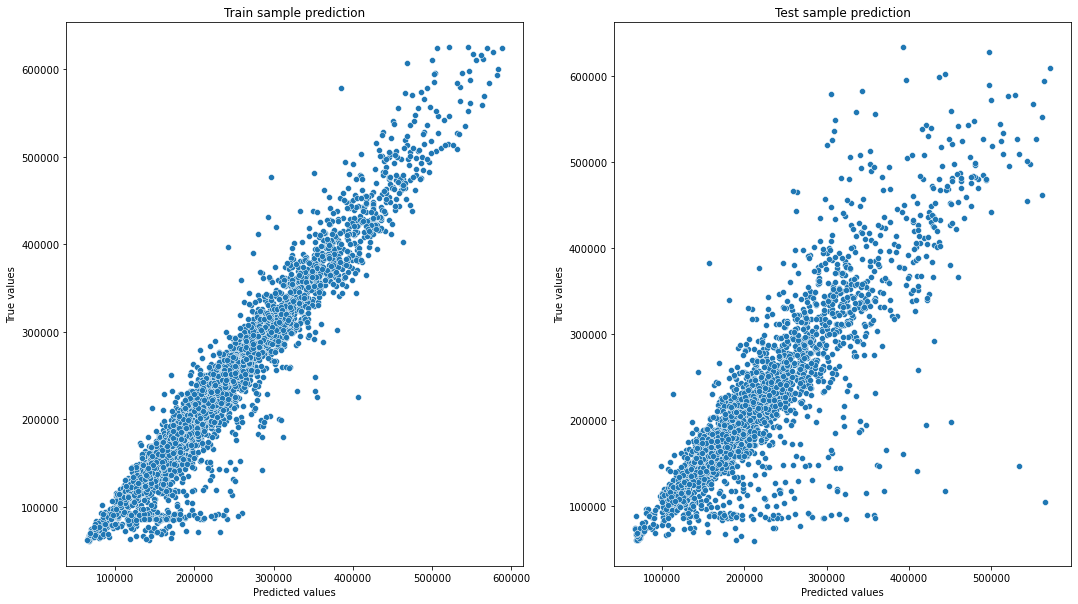

In [175]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

**Перекрёстная проверка**

In [176]:
cv_score = cross_val_score(rf_model, X, y, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.75586311, 0.74627508, 0.75507433])

In [177]:
cv_score.mean()

0.752404171203844

**Важность признаков**

In [178]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
15,MedPriceByDistrict,0.683588
1,Square,0.097208
2,LifeSquare,0.028841
6,HouseYear,0.027209
10,Social_3,0.022785
3,KitchenSquare,0.021615
5,HouseFloor,0.019137
4,Floor,0.018677
9,Social_2,0.016258
7,Ecology_1,0.015708


Когда мы отбросили самые малозначимые признаки: 'Ecology_2_bin', 'Ecology_3_bin', 'Shops_2_bin',  то качество модели немного увеличилось


### Прогнозирование на тестовом датасете

Проведём для тестового датасета те же этапы обработки признаков, что и для тренировочного.

### Приведение типов

In [179]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [180]:
test_df['DistrictId'] = test_df['DistrictId'].astype(str)
train_df['HouseFloor'] = train_df['HouseFloor'].astype(np.int64)

### Аномальные значения

**Количество комнат**

In [181]:
test_df['Rooms'].value_counts()

2.0     2030
1.0     1769
3.0     1099
4.0       90
5.0        7
6.0        2
0.0        2
17.0       1
Name: Rooms, dtype: int64

Заменим значения 0 на 1


In [182]:
test_df.loc[test_df['Rooms'] == 0, 'Rooms'] = 1

**Этажность дома (HouseFloor, Floor)**

In [183]:
test_df['HouseFloor'].sort_values().unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 36., 37., 39., 40.,
       48., 99.])

Нулевые значения заменяем медианой.

In [184]:
test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor'] = test_df['HouseFloor'].median()

**Год постройки дома (HouseYear	)**

In [185]:
test_df['HouseYear'].sort_values()

3253    1908
2       1909
2691    1910
64      1911
1475    1912
        ... 
1039    2020
3255    2020
888     2020
4273    2020
4389    2020
Name: HouseYear, Length: 5000, dtype: int64

Аномалий нет

### Обработка пропусков

In [186]:
(len(test_df) - test_df.count())/len(test_df)

Id               0.0000
DistrictId       0.0000
Rooms            0.0000
Square           0.0000
LifeSquare       0.2082
KitchenSquare    0.0000
Floor            0.0000
HouseFloor       0.0000
HouseYear        0.0000
Ecology_1        0.0000
Ecology_2        0.0000
Ecology_3        0.0000
Social_1         0.0000
Social_2         0.0000
Social_3         0.0000
Healthcare_1     0.4754
Helthcare_2      0.0000
Shops_1          0.0000
Shops_2          0.0000
dtype: float64

Есть пропуски в данных: **LifeSquare** ~21% и **Healthcare_1** ~48%.

Пропусков больше 5%, поэтому удалять мы их не можем, а будем обрабатывать по хитрой формуле: LifeSquare = Square - KitchenSquare - "медиана выражения (Square - LifeSquare - KitchenSquare), на выборке, где значение LifeSquare не пропущено"

In [187]:
square_med_diff = (test_df.loc[test_df['LifeSquare'].notnull(), 'Square'] -\
                   test_df.loc[test_df['LifeSquare'].notnull(), 'LifeSquare'] -\
                   test_df.loc[test_df['LifeSquare'].notnull(), 'KitchenSquare']).median()

square_med_diff

11.387384397363597

In [188]:
test_df.loc[test_df['LifeSquare'].isnull(), 'LifeSquare'] =\
test_df.loc[test_df['LifeSquare'].isnull(), 'Square'] -\
test_df.loc[test_df['LifeSquare'].isnull(), 'KitchenSquare'] -\
square_med_diff
test_df['LifeSquare'].median()

34.3190758440274

Пустые значения **Healthcare_1** заменим просто медианой

In [189]:
test_df.loc[test_df['Healthcare_1'].isnull(), 'Healthcare_1'] = test_df['Healthcare_1'].median()

### Построение новых признаков

**Dummies**

In [190]:
test_df['Ecology_2_bin'] = test_df['Ecology_2'].replace({'A':0, 'B':1})
test_df['Ecology_3_bin'] = test_df['Ecology_3'].replace({'A':0, 'B':1})
test_df['Shops_2_bin'] = test_df['Shops_2'].replace({'A':0, 'B':1})

**Размер района (DistrictSize, IsDistrictLarge)**

In [191]:
district_size = test_df['DistrictId'].value_counts().reset_index().rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
test_df = test_df.merge(district_size, on='DistrictId', how='left')
test_df['IsDistrictLarge'] = (test_df['DistrictSize'] > 100).astype(int)

**Средняя цена по району, с учётом количества комнат (MedPriceByDistrict)**

In [192]:
test_df = test_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')

заполним пропуски средней цены, для районов, которых не было в тренировочной выборке

In [193]:
for r in train_df['Rooms'].unique():
    test_df.loc[test_df['MedPriceByDistrict'].isnull() & test_df['Rooms'] == r, 'MedPriceByDistrict'] = train_df.loc[train_df['Rooms'] == r, 'Price'].median()
    

In [194]:
len(test_df.loc[test_df['MedPriceByDistrict'].isnull()])

0

In [195]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  5000 non-null   int64  
 1   DistrictId          5000 non-null   object 
 2   Rooms               5000 non-null   float64
 3   Square              5000 non-null   float64
 4   LifeSquare          5000 non-null   float64
 5   KitchenSquare       5000 non-null   float64
 6   Floor               5000 non-null   int64  
 7   HouseFloor          5000 non-null   float64
 8   HouseYear           5000 non-null   int64  
 9   Ecology_1           5000 non-null   float64
 10  Ecology_2           5000 non-null   object 
 11  Ecology_3           5000 non-null   object 
 12  Social_1            5000 non-null   int64  
 13  Social_2            5000 non-null   int64  
 14  Social_3            5000 non-null   int64  
 15  Healthcare_1        5000 non-null   float64
 16  Helthc

In [196]:
X_result = test_df[feature_names + new_feature_names]

In [197]:
y_result_preds = rf_model.predict(X_result)

Объединяем пресказанные рузультаты с соответствующими значениями **Id**

In [198]:
df_result = pd.Series(y_result_preds, name='Price', index = test_df['Id'])
df_result.head()

Id
725      165976.710057
15856    241657.639609
5480     153210.220248
15664    322627.493388
14275    145154.892940
Name: Price, dtype: float64

Сохраняем в файл csv

In [199]:
df_result.to_csv('DTarasov_predictions.csv')